Contents:
1) Introduction
2) Compress dataframe
3) DB integration
4) Decompression
5) Performance - Guerilla vs TimescaleDB
6) Batch process - Validation Manager
7) Batch process - Append data
8) Data Features
9) Guerilla vs other compression algorithms

## 1) Introduction

Guerilla Compression is a python library that allows efficient data compression and storage tailored specifically to financial timeseries data.
Although it is centered around the lossless compression functionality, it can also prove useful in the overall workflow of data validation in the process of appending data, as well as in targeted querying for the purpose of generating and backtesting trading strategies.<br><br>


The name guerilla itself is both a play on one of the most popular timeseries compression algorithm - Gorilla, introduced by Facebook and used in some of the most popular compression software, as well as a testament to the way the compression algorithm fights ferociously for performance on both storage and compute fronts.

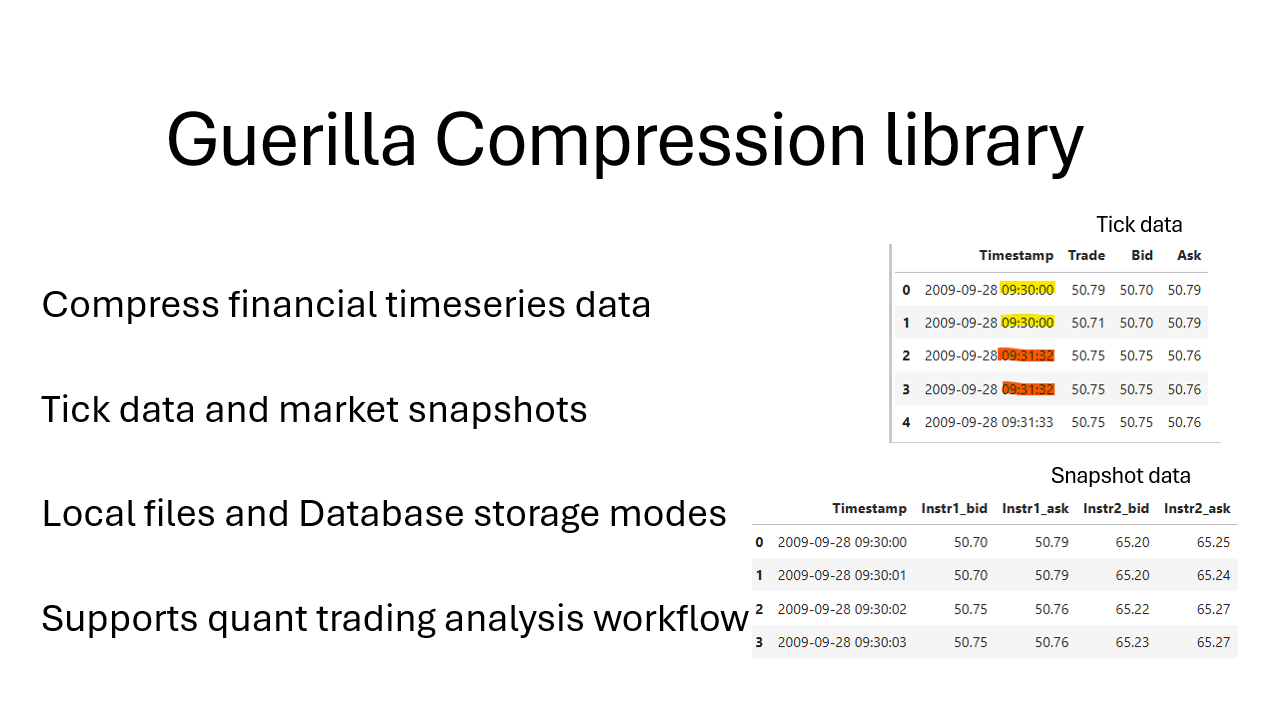

#### Imports, loading data to DataFrame

In [1]:
import guerilla_pack as guerilla
import pandas as pd
input_csv = r'data\kibot_com_all_cols_all.csv'

sql_server=r'localhost\SQLEXPRESS'
sql_database='GuerillaCompression'

In [2]:
# using a free sample of tick data of the S&P Value Index (IVE) from kibot.com:
# https://www.kibot.com/free_historical_data.aspx
df = pd.read_csv(input_csv, parse_dates=['Timestamp'])
print('Number of rows:', len(df))
df.head(3)

Number of rows: 11777292


,Timestamp,Trade,Bid,Ask
0,2009-09-28 09:30:00,50.79,50.70,50.79
1,2009-09-28 09:30:00,50.71,50.70,50.79
2,2009-09-28 09:31:32,50.75,50.75,50.76


#### Initialize GuerillaCompression

In [3]:
gc = guerilla.GuerillaCompression(server=sql_server, database=sql_database, num_workers=1)

## 2) Compress dataframe

In [30]:
df_part = df.iloc[:-100_000]
_ = gc.compress_dataframe(df_part, 
                          timestamp_col="Timestamp", 
                          output_format='db', 
                          data_name='KibotFull',
                          processing_chunk_size=400_000)

2025-05-27 00:12:33,922 - INFO - Metadata saved successfully for KibotFull
2025-05-27 00:12:33,925 - INFO - Compression process complete. Time taken: 22.08 seconds.


Guerilla supports multiprocessing, although there is some overhead due to starting time of child processes. This overhead fades with larger datasets and the performance improvement is more profound. Here the improvement in data ingestion is 14.5 vs 22 seconds. This translates to throughput of 812k and 535k rows/sec.

In [40]:
# changing the number of worker processes to 4
gc.num_workers=4
_ = gc.compress_dataframe(df_part, 
                          timestamp_col="Timestamp", 
                          output_format='db', 
                          data_name='KibotFull',
                          processing_chunk_size=400_000)

2025-05-27 01:11:46,238 - INFO - Metadata saved successfully for KibotFull
2025-05-27 01:11:46,240 - INFO - Compression process complete. Time taken: 14.48 seconds.



Setting higher verbose level, we can see the actual PIDs sending chunks concurrently to the database writer thread (jupyter does not natively support subprocesses printouts, hence the cmd screenshot)
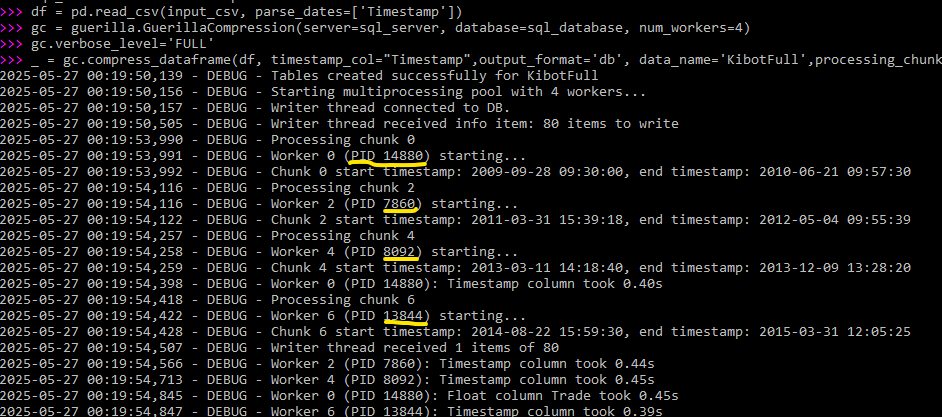

#### Chunk size

Guerilla - as most timesries databases - divides the full dataset into chunks because of more efficient retrieving data. It supports setting the chunk size both based on number of rows as well as a time interval.<br>
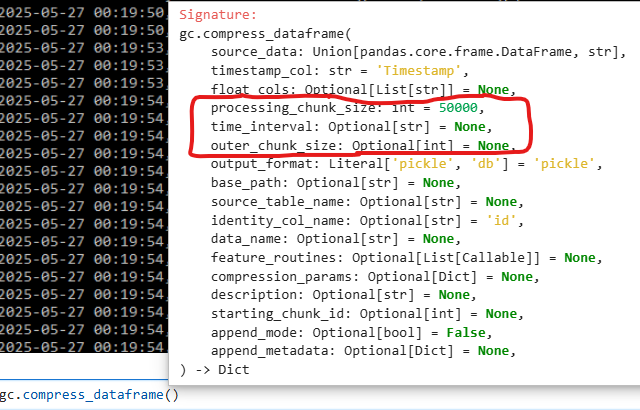<br><br>
It also allows for dataframes to be larger than memory buffer by using a data iterator that yields parts of the full dataset.<br>
Although guerilla natively supports pandas DataFrames, the source data could also be provided as a DB table or a filepath to a csv file

## 3) DB integration

#### What's happening in the DB?

In the DB guerilla actually creates a set of three tables (or four if the user chooses to save market data features - more on that later).<br>
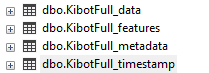

It makes it easier to inspect some of the metadata without running any queries. The actual compressed data resides in the DB as BLOBs. 
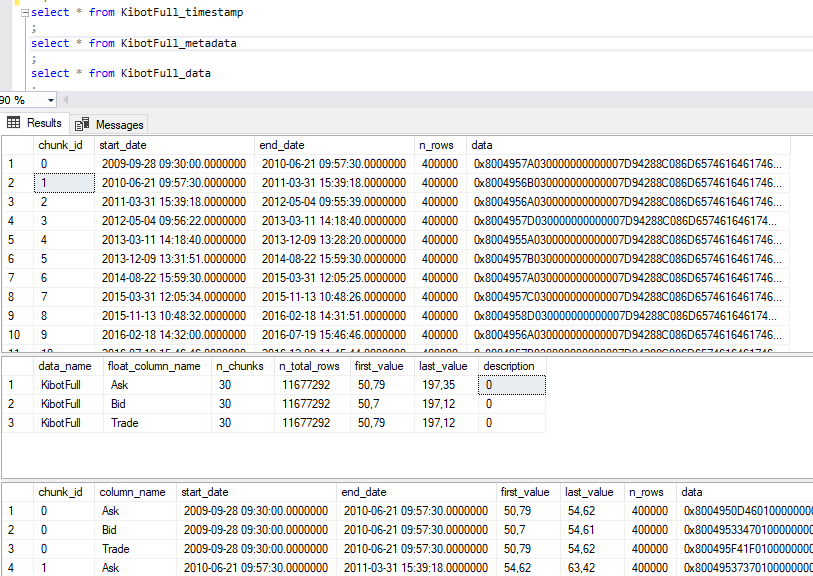
<br><br>

#### Organizing the data for many instruments/markets/asset classes

A logical approach could be to bundle together similar instruments under a dataname in the snapshot paradigm or use a unique id for every financial instrument in the tick data paradigm, as the tick data nature makes it harder for different instruments to be presented together. <br>
To organize the data further, the user can of course use separate databases or schemas, for instance using spearate databases for separate asset classes and schemas for separate markets within an asset class.<br><br>

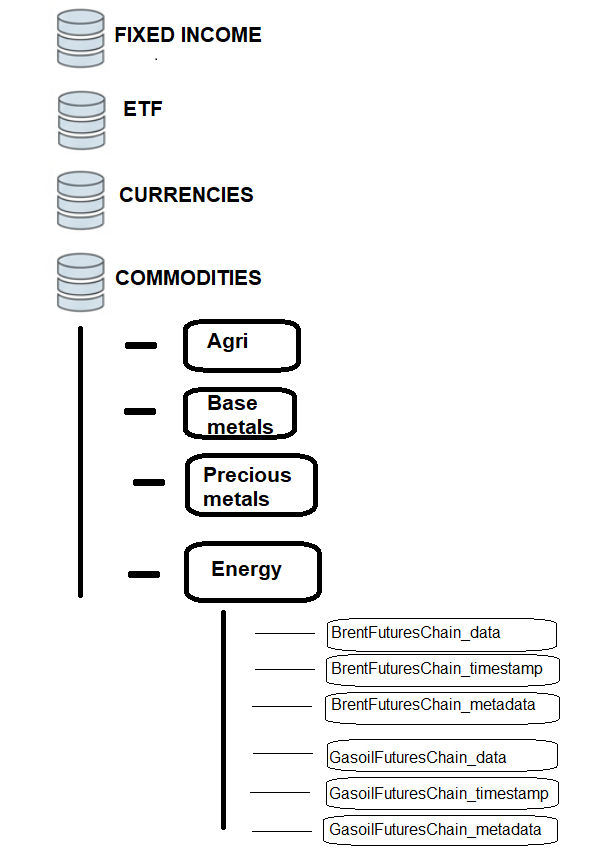
<br>
(the image above isn't exactly world class graphic design but you get the idea)<br><br>
Dividing the full dataset into timestamps and other columns is a design choice that can be useful if the compressed data being stored is in the snapshot paradigm. 
Data chunks use a chunk_id that allows linking them to a timestamp chunk for more efficient storage of timestamps. 
Specifically, if there are a lot of snapshot data with the same trading hours and sampling frequency, saving the timestamps for each of the instruments separately translates into a huge waste of storage. <br>
The timestamp id can mitigate some of this waste, depending on the specific setup. <br><br>

The performance showcased in this presentation does not take advantage of this behaviour, as there is only one instrument presented in the demo and its prices are provided in the tick data paradigm. Hence taking this into consideration for real world scenarios the performance could still be improved.

## 4) Decompression

#### Decompress dataframe - fulll

In [42]:
# not filtering on dates
decompressed_df = gc.decompress_chunked_data(data_name='KibotFull')

2025-05-27 01:13:21,803 - INFO - Reader thread started. Format: db, Chunks: 30
2025-05-27 01:13:21,895 - INFO - Starting imap processing with 4 workers.
2025-05-27 01:13:29,019 - INFO - Reader thread finished loading all requested chunks.
2025-05-27 01:13:29,455 - INFO - Finished iterating through imap results.
2025-05-27 01:13:29,653 - INFO - Decompression complete. Returning 11677292 rows in 7.97 seconds.


In [43]:
# rearrange the columns to match the original column order
decompressed_df = decompressed_df[df.columns]

# compare the original and decompressed DataFrames
if df_part.equals(decompressed_df):
    print('Decompressed data matches the original data')

Decompressed data matches the original data


#### Partial decompression
Fetching only a subset of data based on timestamps is significantly faster

In [47]:
start_time = '2022-01-01'
end_time = '2024-06-30'
decompressed_df_partial = gc.decompress_chunked_data(data_name='KibotFull', 
                                                     start_time=start_time, 
                                                     end_time=end_time)

2025-05-27 01:14:50,556 - INFO - Reader thread started. Format: db, Chunks: 6
2025-05-27 01:14:50,657 - INFO - Starting imap processing with 4 workers.
2025-05-27 01:14:51,209 - INFO - Reader thread finished loading all requested chunks.
2025-05-27 01:14:54,762 - INFO - Finished iterating through imap results.
2025-05-27 01:14:55,119 - INFO - Decompression complete. Returning 2013441 rows in 4.68 seconds.


In [48]:
# filter the original DataFrame
df_partial = df[(df['Timestamp']>= pd.to_datetime(start_time)) & (
    df['Timestamp']<=pd.to_datetime(end_time))]

# reset index for both slice of the original and decompressed DataFrames
df_partial.reset_index(drop=True, inplace=True)
decompressed_df_partial.reset_index(drop=True, inplace=True)

# rearrange the columns in the decompressed DataFrame
decompressed_df_partial = decompressed_df_partial[df_partial.columns]

# compare the original and decompressed DataFrames
if df_partial.equals(decompressed_df_partial):
    print('Decompressed partial data matches the original partial data')

Decompressed partial data matches the original partial data


## 5) Performance - Guerilla vs TimescaleDB

Arguably the most popular software for timeseries compression and storage is TimescaleDB. Let's compare the storage requirements for the same
reference data.<br><br>
Since TimescaleDB uses postgres, we will also switch to the same DBMS. Setting the server, database or dbms properties causes the GuerillaCompression instance to get a new db_handler

In [49]:
# switch to postgres
pg_server = 'localhost'
pg_database = 'GuerillaCompression'

gc.dbms = 'postgres'
gc.server = pg_server
gc.database = pg_database

TimescaleDB uses time interval as a primary guidance for chunk size. Setting 6 months for both Guerilla and Timescale

In [51]:
# note this time we're compressing the full df, not df_part
# part of the original df has been withheld when writing to SQLServer to show the append functionality later
_ = gc.compress_dataframe(df, 
                          timestamp_col="Timestamp", 
                          output_format='db', 
                          data_name='kibotfull', 
                         time_interval='6 months')

2025-05-27 01:25:09,046 - INFO - Metadata saved successfully for kibotfull
2025-05-27 01:25:09,048 - INFO - Compression process complete. Time taken: 17.47 seconds.


Guerilla took 17 seconds with up to around 70% CPU usage. 
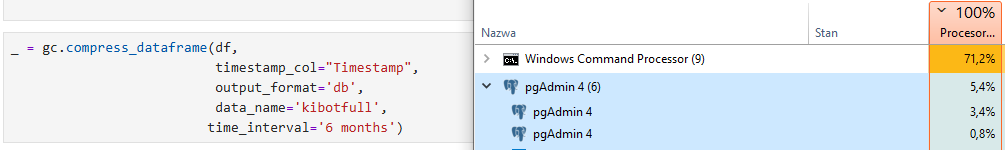

Let's see how well Timescale does for the same data. This is the full code I'm using in pgAdmin:
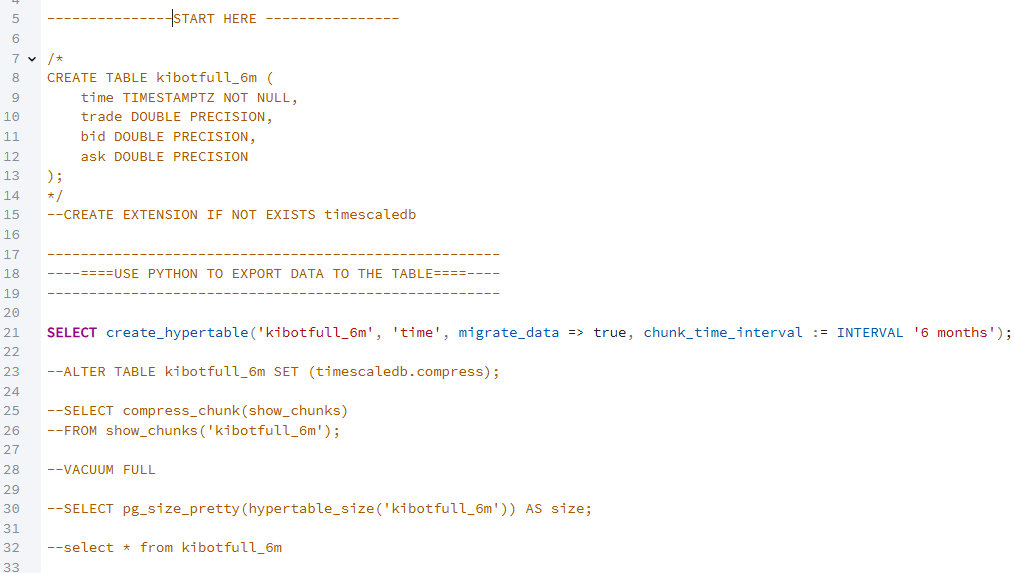

#### I want to make it very clear: 
##### I'm not entirely sure I'm compressing the data in the most efficient way in TimescaleDB.
##### I'm also aware that the comparison methodology is not bulletproof
Having said that, the difference is too stark and replicable not to draw any conclusions.
With the Postgres code above, there are three statements that actually take a lot of time:
1) exporting the data from python (over 200 seconds)
2) SELECT create_hypertable... (87 seconds)
3) SELECT compress_chunk... (21 seconds)
<br>
Item 1 (exporting dataframe to DB) might be very specific to my use scenario and not represent the real world usage. Items 2 and 3 however seem to be commonplace in data ingestion in TimescaleDB. A robust comparison of the CPU time needed for ingestion would have to take into account that pgAdmin was taking up less CPU (max 50% at times) than Guerilla. <br><br>

##### Still, the difference in throughput is massive.
Counting only steps 2 and 3 for TimescaleDB, it's still 108 seconds vs 17 seconds for Guerilla. Whatever CPU usage adjustment would be factored in, Guerilla is the clear winner in this - somewhat flawed - comparison. 

## Memory used - Guerilla vs TimescaleDB

As much as the comparison of the required compute is up for debate because of the methodology and equipment, the compressed size comparison leaves no room for guessing.<br>
TimescaleDB requires 145 MB of disk space, while Guerilla needs about 18.4 MB.
#### That's 87% less storage required.
This has been replicated many times, with different time itervals and number of chunks. The more chunks the worse the compression gets with both Timescale and Guerilla, but the ratio of well over 80% of storage savings persists.

<br><br>
TimescaleDB:<br>
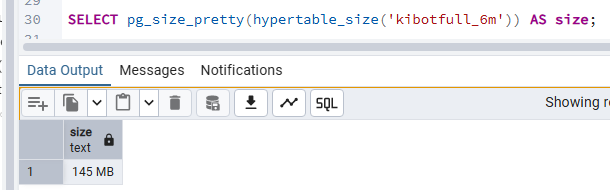

<br><br>
Guerilla:<br>
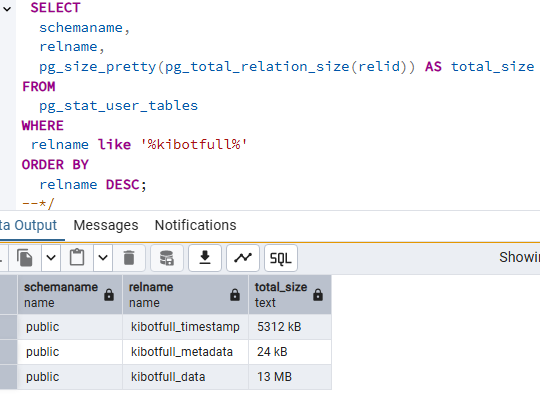

Here are the results based on a number of runs with both tick data and snapshot data

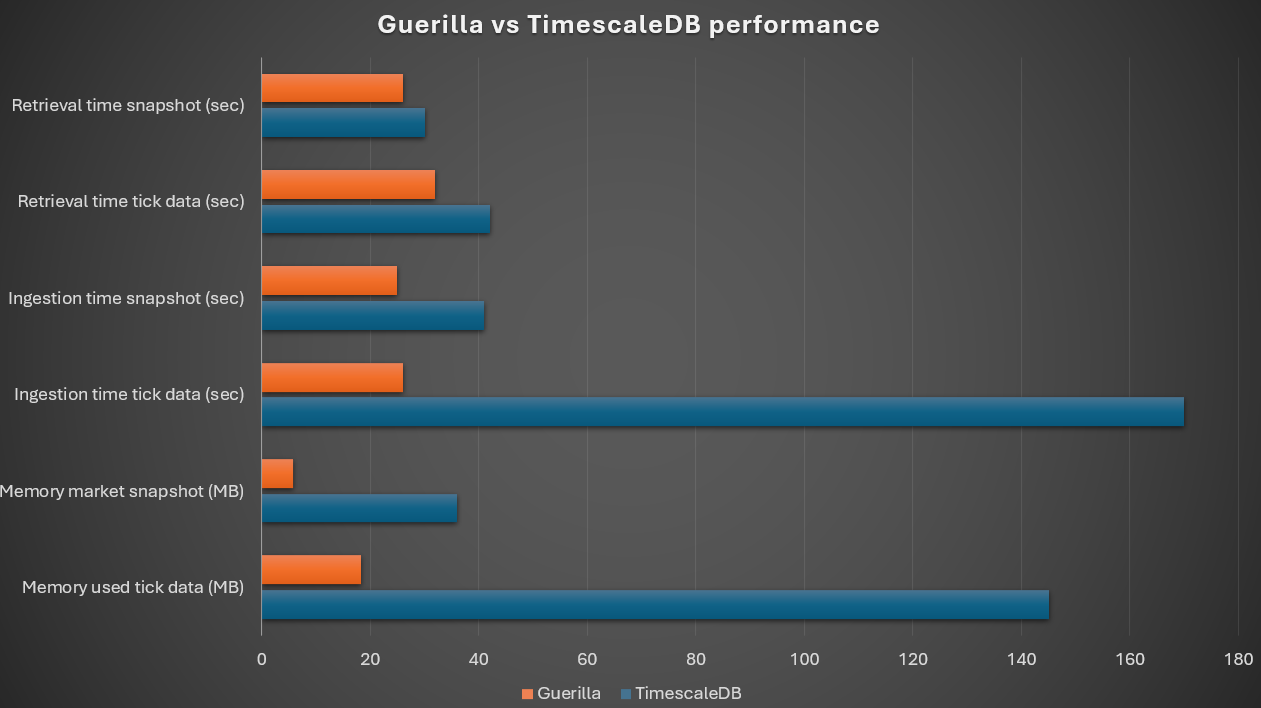

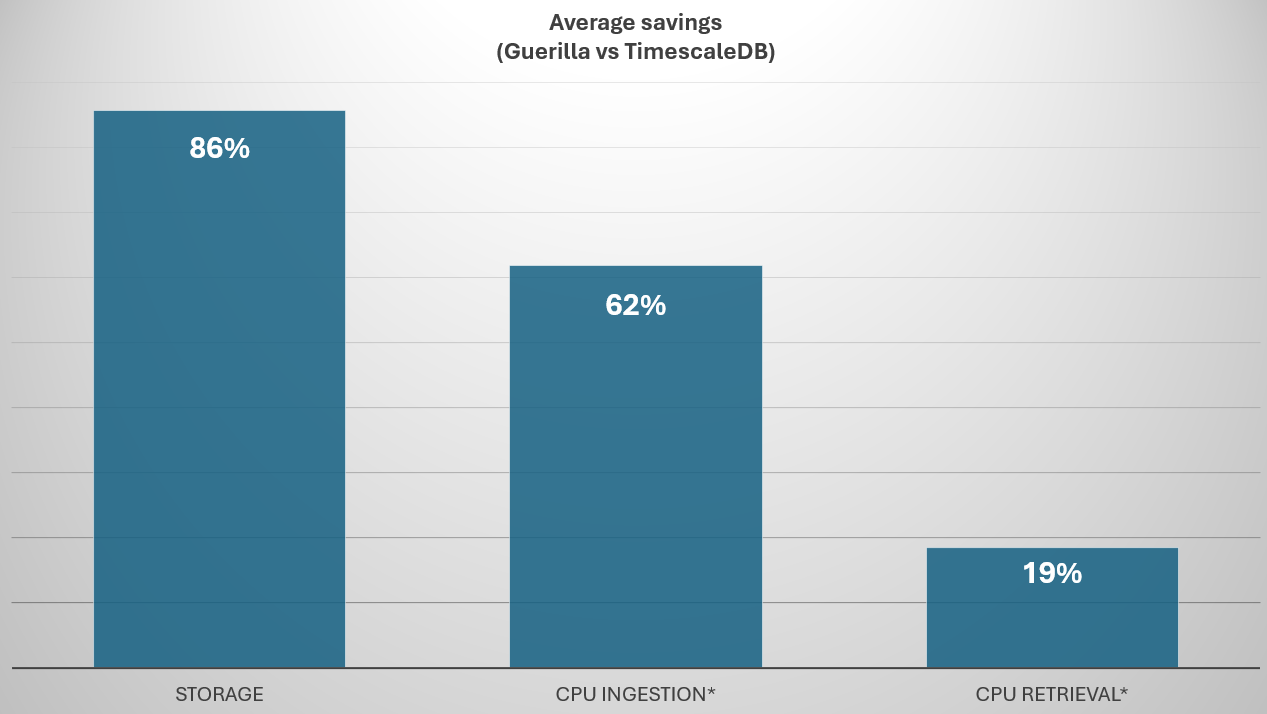

The CPU numbers have a star (*) because of the aforementioned ambiguity, as well as the fact that Guerilla and Timescale use different starting points - TimescaleDB uses a DB table (later turned into a hypertable) as input and a query result in pgAdmin as output (when querying) while Guerilla relies mostly on pandas DataFrames as raw input and final output. It ultimately depends on the use case which approach is better preferred.

#### For the use cases considered, Guerilla Compression could save up to the range of 50%-80% in storage and compute costs compared to TimescaleDB

### Back to guerilla workflow 

## 6) Batch process - Validation Manager

Before the incremental update actually takes place, some quality check of the data should be performed. This is where ValidationManager comes in.
<br><br>
While the valdiation manager is not essential to the guerilla compression library and may very well be replaced by other workflow managers that handle validation process,
it is still a nice-to-have, especially if one does not yet have a robust validation in place managed by an established orchestrator.

In [55]:
# change dbms back to sqlserver
gc.dbms = 'sqlserver'
gc.server = sql_server
gc.database = sql_database


vm = guerilla.ValidationManager()

Validation Manager can inspect the data validation procedures for the data batch, run these procedures and update their parameters.
Let's take a look at what validation procedures are in place. Note these are stored procedures defined at the SQLServer level.

In [56]:
vm.procedure_lookup(show_parameters=False)


Procedure: ValidateTradeUpsampled
Description: Bad tick validation for table KibotUpsampledBatch, column Trade
--------------------------------------------------------------------------------

Procedure: ValidateTimestep
Description: Timestep validation for table KibotUpsampledBatch, column Timestamp
--------------------------------------------------------------------------------


The procedures are performed on the data sitting the the DB, not loaded from an external source, although this could also be arranged.<br>
The procedures are set up in a way to both avoid dynamic SQL for security reasons but at the same time allow for some flexibility with the parameters. To strike this compromise a table is used that holds the values of the parameters for each procedure. The table is structured in a way that enables it to handle all the procedures in the database.<br> 
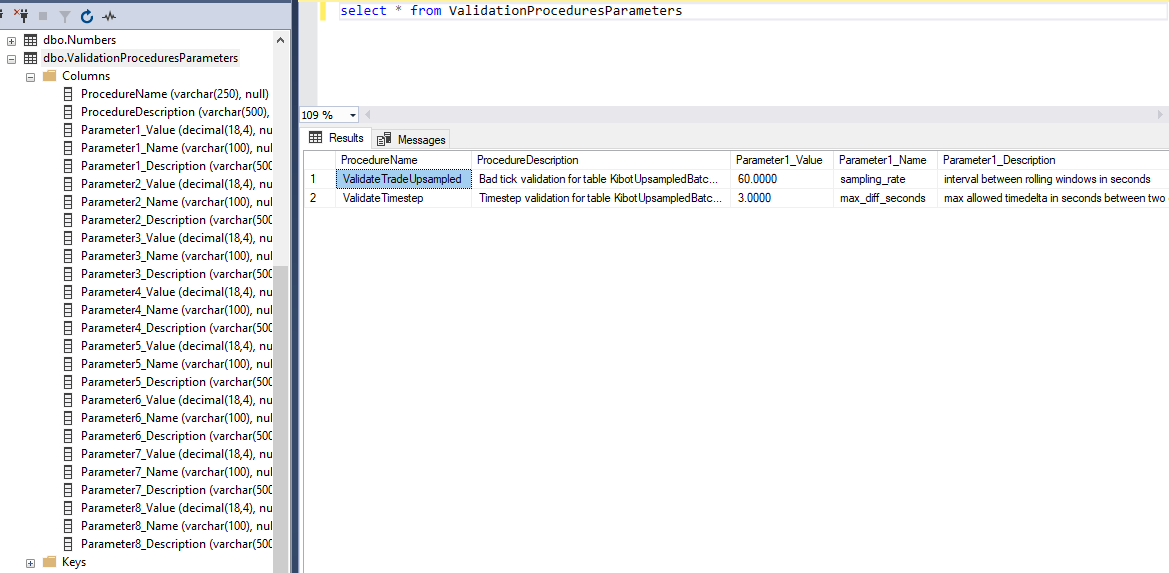
<br><br>
The appropriate casting of parameters is done in the relevant procedure code.<br>
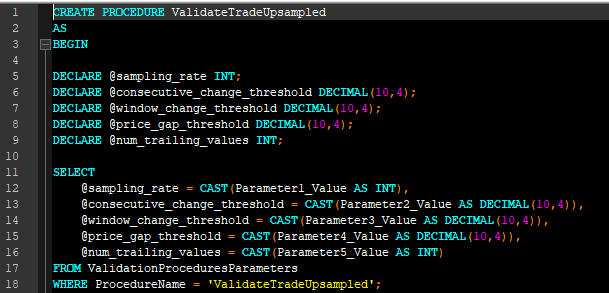

Let's have a look at the detailed run down of the procedures and their parameters, this time with the show_parameters set to True

In [57]:
vm.procedure_lookup(show_parameters=True)


Procedure: ValidateTradeUpsampled
Description: Bad tick validation for table KibotUpsampledBatch, column Trade

Parameters:
  sampling_rate:
    Value: 60.0000
    Description: interval between rolling windows in seconds
  consecutive_change_threshold:
    Value: 0.0010
    Description: minimum change between consecutive values to flag as bad tick
  window_change_threshold:
    Value: 0.0001
    Description: minimum change between the extreme value of the time window and final value of the window
  price_gap_threshold:
    Value: 0.2000
    Description: fraction of the difference between final window value and extreme, values outside of which are considered trailing values
  num_trailing_values:
    Value: 2.0000
    Description: minimum number of trailing values to consider the extreme a valid datapoint
--------------------------------------------------------------------------------

Procedure: ValidateTimestep
Description: Timestep validation for table KibotUpsampledBatch, column Ti

In [58]:
validation_results = vm.run_validation()

Running ValidateTradeUpsampled...
Running ValidateTimestep...

ValidateTradeUpsampled:
Validation passed

ValidateTimestep:
Validation passed


To demonstrate the procedure of flagging potentially bad ticks, let's modify a single datapoint to show a 10% jump and the run the validation again.

In [60]:
# Create a bad tick - suspected price datapoint: increase the 1000th value by 10%
import pyodbc
conn = pyodbc.connect(vm.conn_str)
cursor = conn.cursor()

sql = """
WITH RowNumberCTE AS (
    SELECT
        Timestamp,
        Trade,
        ROW_NUMBER() OVER (ORDER BY Timestamp) AS RowNum
    FROM
        dbo.KibotUpsampledBatch
)
-- Update the Trade value for the row where RowNum is 1000
UPDATE dbo.KibotUpsampledBatch
SET Trade = Trade * 1.10  -- Increase Trade by 10%
WHERE Timestamp IN (SELECT Timestamp FROM RowNumberCTE WHERE RowNum = 1000);
"""
cursor.execute(sql)
conn.commit()
conn.close()

In [61]:
# running only the ValidateTradeUpsampled procedure
validation_results = vm.run_validation(['ValidateTradeUpsampled'])

Running ValidateTradeUpsampled...

ValidateTradeUpsampled:
Validation failed - found 5 results:
['PriceTimestamp', 'FilledTrade', 'ExtremeValue', 'ExtremeTimestamp', 'TrailingObservations']
['2025-03-19 09:46:59.0000000', 189.78, 208.681, '2025-03-19 09:46:40.0000000', 1]
['2025-03-19 09:47:59.0000000', 189.79, 208.681, '2025-03-19 09:46:40.0000000', 1]
['2025-03-19 09:48:59.0000000', 189.99, 208.681, '2025-03-19 09:46:40.0000000', 1]
['2025-03-19 09:49:59.0000000', 189.99, 208.681, '2025-03-19 09:46:40.0000000', 1]
['2025-03-19 09:50:59.0000000', 189.99, 208.681, '2025-03-19 09:46:40.0000000', 1]


The validation procedure finds 5 time windows with suspected value. Clearly the results could use some filtering, but this really is a POC at this point. The Validation Manager should be part of a workflow and trigger further action failing any of the tests.<br><br>
To demonstrate the parameter handling via Validation Manager, let's decrease the sensitivity of the validation procedure by updating one of its parameters.

In [62]:
# changing the maximum allowed jump between consecutive observations to 20%
vm.procedure_update(procedure_name='ValidateTradeUpsampled', parameter_name='consecutive_change_threshold', new_value=0.2)

Updated consecutive_change_threshold to 0.2 for ValidateTradeUpsampled


In [63]:
# running only the ValidateTradeUpsampled procedure again with the new parameter
validation_results = vm.run_validation(['ValidateTradeUpsampled'])

Running ValidateTradeUpsampled...

ValidateTradeUpsampled:
Validation passed


As expected, the check is passed. This concludes the presentation of ValidationManager. Before moving on, let's just change the value in the batch and the parameter back to their original values

In [64]:
vm.procedure_update(procedure_name='ValidateTradeUpsampled', parameter_name='consecutive_change_threshold', new_value=0.001)

conn = pyodbc.connect(vm.conn_str)
cursor = conn.cursor()

sql = """
WITH RowNumberCTE AS (
    SELECT
        Timestamp,
        Trade,
        ROW_NUMBER() OVER (ORDER BY Timestamp) AS RowNum
    FROM
        dbo.KibotUpsampledBatch
)
-- Update the Trade value for the row where RowNum is 1000
UPDATE dbo.KibotUpsampledBatch
SET Trade = Trade / 1.10  -- Decrease Trade by 10%
WHERE Timestamp IN (SELECT Timestamp FROM RowNumberCTE WHERE RowNum = 1000);
"""
cursor.execute(sql)
conn.commit()
conn.close()

Updated consecutive_change_threshold to 0.001 for ValidateTradeUpsampled


## 7) Batch process - Append data

In [7]:
feature_routines=['numerical', 'categorical']
_ = gc.append_compressed('KibotBatch', 'KibotFull', chunk_size=25_000, new_chunk=True, feature_routines=feature_routines)

2025-05-27 15:09:13,206 - INFO - Using identity column 'id' for ordering.
2025-05-27 15:09:14,137 - INFO - Auto-detected float columns: ['Trade', 'Bid', 'Ask']
2025-05-27 15:09:28,011 - INFO - Metadata saved successfully for KibotFull
2025-05-27 15:09:28,022 - INFO - Compression process complete. Time taken: 13.78 seconds.


Guerilla offers the append method that could be integrated in a workflow manager.<br>
The supported types of new data source are again a DB table, a csv file or a in-memory pandas DataFrame. This allows for easy integration with other parts of the data ingestion workflow.<br><br>
Once the data is appended the metadata table will be updated to reflect the new metadata such as number of chunks and rows.
Guerilla offers appending to an existing chunk or a new chunk, depending on the desired size of the chunks and batch process frequency.

## 8) Data features

This is where Guerilla's focus on financial markets really shine. You might have noticed the appending of 100k rows took quite a long time compared to over 11 million rows earlier. This is because appending allows to add something that is called "data features". <br><br>

Data features are some characteristics of the data that are computed on the fly on the raw data and can be inspected later
without decompressing the full data. The idea is that for part of the trading analysis or strategy backtesting some of the data subsets are much more useful 
than others.<br><br>
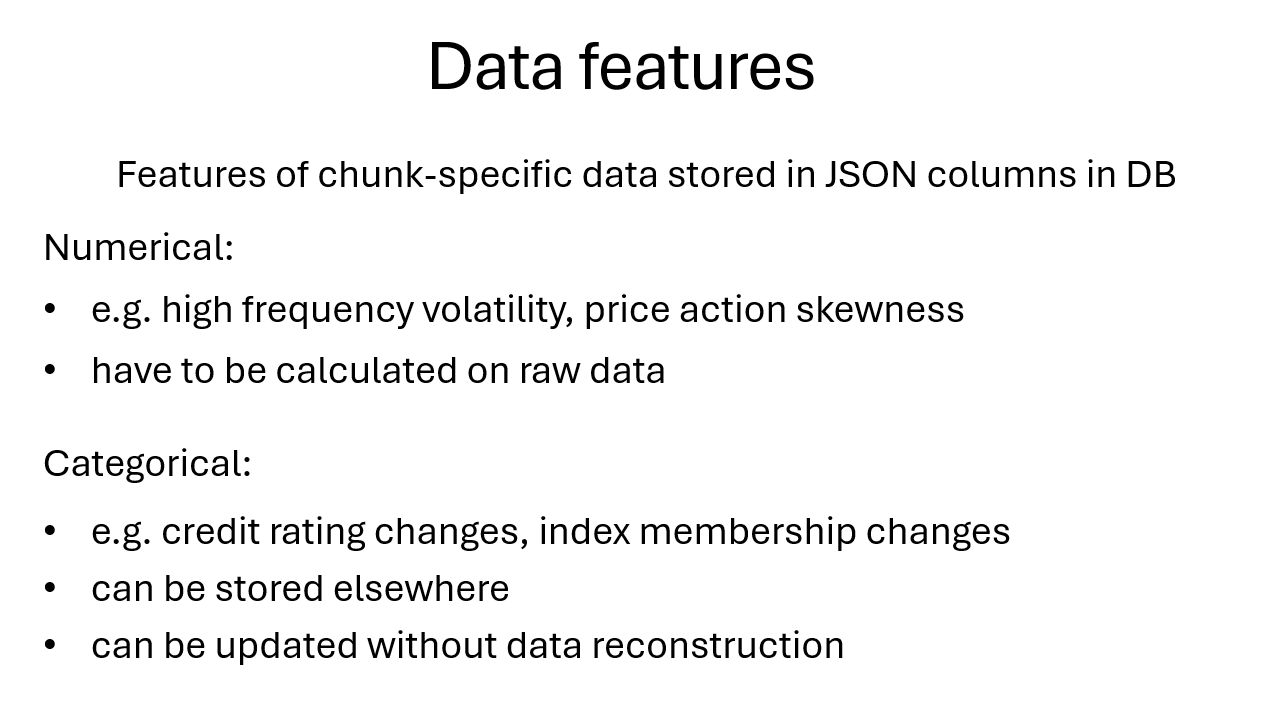
<br><br>


There are certainly more than a few cases where these data features might be useful, but two that stand out the most are:
<br>
##### 1) Speeds up strategy generation process
##### 2) Speeds up setting up backtesting or retraining with specific market conditions
<br>
For a more detailed explanation on what that entails consider the description below: <br><br>

A trader is working on a strategy that is expected to be useful in high volatility markets. <br>
It is wasteful to decompress all of the data and only then filter the data for the desired levels of volatility to arrive at the final training data for the strategy. Some of the filtering can be done based on the features calculated during batch processing, so that only the relevant chunks are decompressed for analysis. Of course many of such features, including popular technical analysis indicators, such as moving averages, may be easily accessed without this functionality, as their values can be found in many financial services. <br>
More custom indicators however, especially the ones *needing very granular data* to be computed, are much harder to get by. Some indicators are impossible to compute using aggregated data - usually easily available - with say a 1 minute interval. An example of such a metric is the price_jump_skew, which measures how skewed to the bid or offer are large price jumps within a short time window. This indicates a certain mood of the market, that can be used as a basis or a filter for a trading strategy.

The other example goes sort of the other way around. <br>
Let's say there is an active strategy running on an instrument and a sudden event relating to this instrument takes place. 
<br>
Perhaps the most obvious instance would be a stock which is suddenly downgraded in terms of credit rating. How relevant is that with regards to the running trading strategy? *Should you stop the strategy on this particular stock because it got downgraded?* <br>
It certainly can affect the trading patterns on this instrument. Probably best way to move forward is to run the backtests or fine tune the parameters on a specific subset of training data with this specific type of event being considered. You can of course look for credit downgrade dates on a number of stocks in one service or database, then retrieve the data around these dates for these particular stocks. <br>
<br>
The value of data features in guerilla however is that this can be accessed directly in a single system, without the need to query other systems and feed the requirements to a separate timeseries database. Guerilla can have a multitude of these data features calculated and stored in json in your database, so running the analysis on the relevant data is done with fewer steps. 


##### Let's see how this is implemented in the DB<br><br>
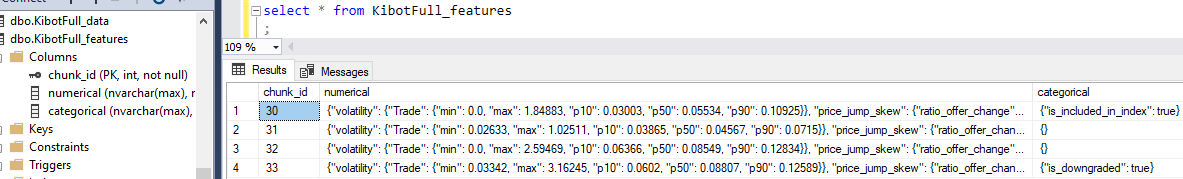
<br><br>

There is a fourth table with a suffix "_features" and it contains columns storing json like information on numerical and categorical
features for each of the chunk ids.
<br>
The choice of features to calculate is defined in the feature_routines.py file that is intended to be easily adjusted by the user. The actual feature calculations are defined in another file called features.py and are imported in feature_routines
<br><br>
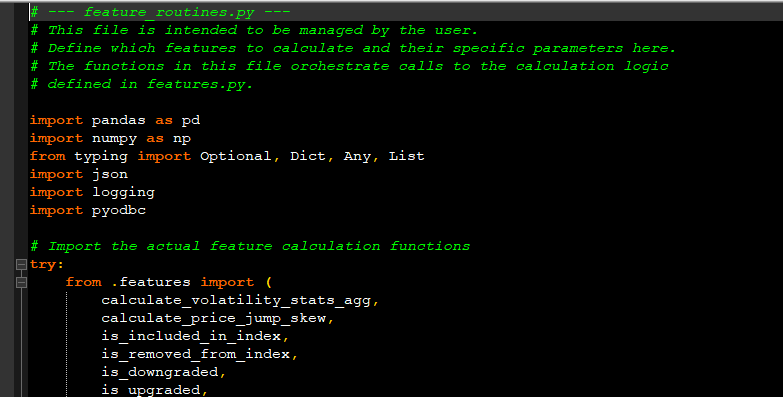

<br><br>
The parameters for each calculated feature can be easily altered in the feature_routines.py file...
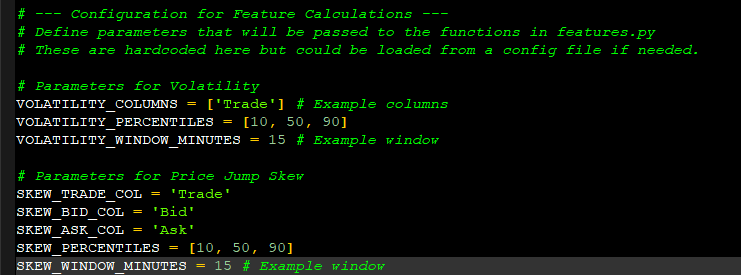
<br><br>
... while the calculate_numerical_features and calculate_categorical_features functions define which of the calculations should be included in a given routine
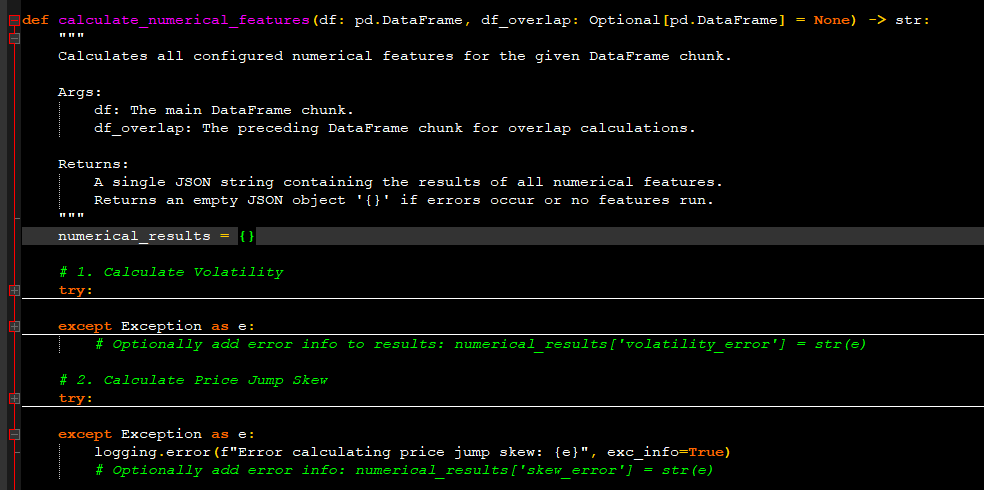

<br><br>
There may be several different routines and the final choice of which should be performed is passed as an argument to the GuerillaCompression.append_compressed() method

Once the data features are calculated and stored in a dedicated DB table, they can be used to quickly identify data chunks that satisfy the conditions. This is done with a simple GuerillaCompression.feature_lookup method that uses JSON formatted strings as conditions. Let's say that we want to analyze a potential strategy that would be implemented in high volatility setting with significant price action pressure on the buying side.

In [14]:
# Test feature lookup - conjuction
numerical_conditions = {
    'volatility': {
        'Trade': {'p90': {'>': 0.12}}
    },
    'price_jump_skew': {
        'ratio_bid_change': {'p90': {'>': 0.45}},
        'ratio_bid_pressure': {'p50': {'>': 0.5}}
    }
}
chunks = gc.feature_lookup('KibotFull',
    numerical_conditions=numerical_conditions,
    categorical_conditions=[],
    operator='AND'
)
print(chunks)

[32, 33]


Notice the lookup accepts both "AND" as well as "OR" operator which makes it easier to structure more complex queries

In [15]:
# Test feature lookup - disjunction
numerical_conditions = {
    'volatility': {
        'Trade': {'p90': {'>': 0.12}}
    },
    'price_jump_skew': {
        'ratio_bid_change': {'p90': {'>': 0.45}},
        'ratio_bid_pressure': {'p50': {'>': 0.5}}
    }
}
chunks = gc.feature_lookup('KibotFull',
    numerical_conditions=numerical_conditions,
    categorical_conditions=[],
    operator='OR'
)
print(chunks)

[30, 32, 33]


With the timestamp metadata easily available in the DB the chunk numbers could be easily integrated into the start_time and end_time arguments for fetching and reconstructing the compressed data

#### Data features - summary
What this data features functionality does in essence is it shortens the path between an idea or an external trigger and the arriving at an informed data-driven decision and action. <br>
***It enables to iterate through ideas with less effort.*** <br>
With market moods and patterns shifting quickly, this translates 
into a greater chance of seizing the opportunities before they go away, which can make a substantial difference in terms of overall trading results.

## 9) Guerilla vs other compression algorithms

Here is a comparison of the compression efficiency of Guerilla vs some other compression algorithms.<br><br>
The benchmarks include six algorithms - four available in Windows 7zip (Bzip, PPMd, LZMA and LZMA2), the standalone Gorilla algorithm (an implementation available as a python library - https://github.com/ghilesmeddour/gorilla-time-series-compression) and the proprietary algorithm used by VictoriaMetrics. <br>
The choice of compression algorithms was made on the basis of availability and relevance to the tasks that Guerilla is designed to handle.<br>
The 7zip algorithms were easily available and little to no parametrization is needed to use them properly. <br>
Gorilla (published by Facebook) is often used by TSDB (primarily TimescaleDB). <br><br>
VictoriaMetrics is often referred to as being the best in terms of compression ratio among the time series database solutions.<br>
One may note that VictoriaMetrics has no compression time in the chart. This is because the compression time achieved was so bad that it's almost certain the ingestion could have been done in a more efficient manner.<br><br>

Other popular solutions such as InfluxDB or QuestDB were considered, but in all honesty the UX on Windows for these solutions was rather terrible and the time spent on troubleshooting was deemed not worth it, considering neither of these two solutions is said to be the most efficient in terms of compression ratio. Instead, the focus was moved to VictoriaMetrics which seemed to be the toughest benchmark available.


The compression time is measured with roughly the same CPU usage across all algorithms and uses local files for disk space comparison. <br>
One might notice, that the Bzip performance is missing - this is because it was so bad on both fronts that it would require a separate scale on the chart.



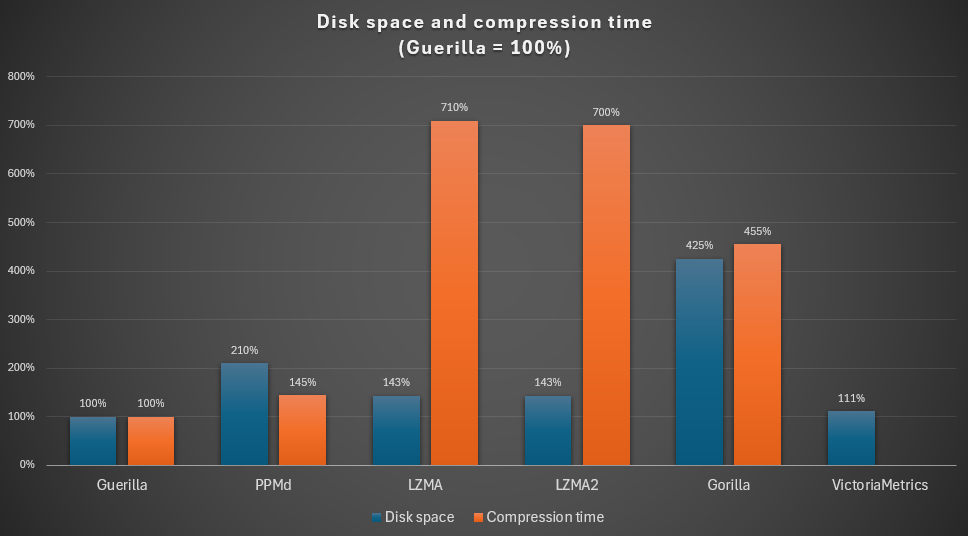
<br><br>
***Guerilla beats all of the other compression algorithms - most of them pretty decisively - offering substantial savings on compute and storage***
<br><br>
It must be noted that despite best efforts, some inefficiencies in using the other algorithms may have occured.<br>
Having said that, Guerilla's performance can also be improved by up to around 15% on a specific implementation, depending on the actual needs, data management setup and the compute vs storage tradeoffs accepted.